<a href="https://colab.research.google.com/github/IzmailovRuslan/super-duper-giggle/blob/main/GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Generative adversarial networks</b></h3>



В этом блокноте обучим GAN для генерации лиц людей

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder, VisionDataset
import torchvision.transforms as tt
from torchvision import models
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

## Часть 1. Подготовка данных 

В качестве обучающей выборки берем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

In [ ]:
# Подключает к ноутбуку наш диск гугл-драйв
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
# Выясняем, как называется наш корневой каталог
!ls /content/gdrive/

MyDrive


In [ ]:
# Убедимся, что ранее загруженный архив виден
!ls -l /content/gdrive/MyDrive/faces_dataset_small.zip

-rw------- 1 root root 4282156752 May 24 10:37 /content/gdrive/MyDrive/faces_dataset_small.zip


In [ ]:
# Распаковываем архив
!unzip -q /content/gdrive/MyDrive/faces_dataset_small.zip

In [ ]:
# Параметры нормализации
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
def get_dataloader(image_size, batch_size):
  DATA_DIR = '/content/root/'

  train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))
  return DataLoader(train_ds, batch_size, shuffle=True)

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
image_size = 128
batch_size = 64

train_dl = get_dataloader(image_size, batch_size)

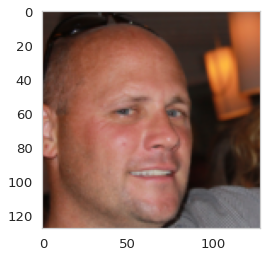

In [ ]:
# Проверяем, корректно ли создан DataLoader
sns.set_style("whitegrid", {'axes.grid' : False})
for batch, _ in train_dl:
  for img in batch:
    plt.imshow(denorm(img.transpose(0,1).transpose(1,2).cpu()))
    break
  break

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)    

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

## Часть 2. Построение и обучение модели 

* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 128 x 128
    nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 64 x 64

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 8 x 8

    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 1024 x 4 x 4

    nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    # out: 1024 x 4 x 4

    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 8 x 8

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 16 x 16

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 64 x 64

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
    nn.Tanh()
    # out: 3 x 128 x 128
)

Алгоритм обучения GANа:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
lr = 0.0002
epochs = 50

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [ ]:
def fit(model, criterion, epochs, lr):
    model["discriminator"].train()
    model["generator"].train()
    model["discriminator"].to(device)
    model["generator"].to(device)
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
history = fit(model, criterion, epochs, lr)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 13.3870, loss_d: 0.9218, real_score: 0.8676, fake_score: 0.2044


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 8.2817, loss_d: 0.7470, real_score: 0.8633, fake_score: 0.1641


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 7.1763, loss_d: 0.3142, real_score: 0.9172, fake_score: 0.0921


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 6.6799, loss_d: 0.1751, real_score: 0.9541, fake_score: 0.0751


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 7.2533, loss_d: 0.4591, real_score: 0.9224, fake_score: 0.0795


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 7.6060, loss_d: 0.1342, real_score: 0.9542, fake_score: 0.0620


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 10.4201, loss_d: 0.0671, real_score: 0.9742, fake_score: 0.0268


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 7.9201, loss_d: 0.0256, real_score: 0.9882, fake_score: 0.0117


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 7.5562, loss_d: 0.0150, real_score: 0.9925, fake_score: 0.0069


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 7.7673, loss_d: 0.0103, real_score: 0.9944, fake_score: 0.0045


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 8.1564, loss_d: 0.3923, real_score: 0.9295, fake_score: 0.0447


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 5.3556, loss_d: 0.9171, real_score: 0.8177, fake_score: 0.1732


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 3.7884, loss_d: 0.8569, real_score: 0.7837, fake_score: 0.1970


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 3.7839, loss_d: 0.6468, real_score: 0.7894, fake_score: 0.2063


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 3.5767, loss_d: 0.9005, real_score: 0.7491, fake_score: 0.2535


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 3.7972, loss_d: 0.9119, real_score: 0.7424, fake_score: 0.2451


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 3.8531, loss_d: 0.7660, real_score: 0.7770, fake_score: 0.2437


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 4.2369, loss_d: 0.7520, real_score: 0.7751, fake_score: 0.2314


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 4.5697, loss_d: 0.8209, real_score: 0.7529, fake_score: 0.2378


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 4.5336, loss_d: 0.7074, real_score: 0.7837, fake_score: 0.2237


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 4.4924, loss_d: 0.8713, real_score: 0.7467, fake_score: 0.2487


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 4.4775, loss_d: 0.6573, real_score: 0.7778, fake_score: 0.2167


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 4.0093, loss_d: 0.8196, real_score: 0.7522, fake_score: 0.2455


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 4.0671, loss_d: 0.9585, real_score: 0.7197, fake_score: 0.2807


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 3.9860, loss_d: 0.9432, real_score: 0.7228, fake_score: 0.2802


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 4.0113, loss_d: 0.9023, real_score: 0.7181, fake_score: 0.2807


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 3.8685, loss_d: 0.8956, real_score: 0.7299, fake_score: 0.2705


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 3.9533, loss_d: 0.8872, real_score: 0.7272, fake_score: 0.2660


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 3.8649, loss_d: 0.9557, real_score: 0.7111, fake_score: 0.2829


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 3.6653, loss_d: 0.8429, real_score: 0.7304, fake_score: 0.2754


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 3.7938, loss_d: 0.9044, real_score: 0.7170, fake_score: 0.2745


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 3.8865, loss_d: 0.8174, real_score: 0.7311, fake_score: 0.2705


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 3.5680, loss_d: 0.9809, real_score: 0.7052, fake_score: 0.2869


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 3.7702, loss_d: 0.7607, real_score: 0.7535, fake_score: 0.2507


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 3.8356, loss_d: 0.8332, real_score: 0.7335, fake_score: 0.2601


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 4.1073, loss_d: 0.7730, real_score: 0.7519, fake_score: 0.2458


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 4.1468, loss_d: 0.7643, real_score: 0.7558, fake_score: 0.2443


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 4.1186, loss_d: 0.7324, real_score: 0.7528, fake_score: 0.2354


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 4.1260, loss_d: 0.7682, real_score: 0.7562, fake_score: 0.2503


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 4.3617, loss_d: 0.7677, real_score: 0.7611, fake_score: 0.2368


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 4.0098, loss_d: 0.6730, real_score: 0.7683, fake_score: 0.2150


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 4.6206, loss_d: 0.7373, real_score: 0.7705, fake_score: 0.2352


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 4.3036, loss_d: 0.7181, real_score: 0.7657, fake_score: 0.2294


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 4.2737, loss_d: 0.6607, real_score: 0.7784, fake_score: 0.2183


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 4.5154, loss_d: 0.6440, real_score: 0.7957, fake_score: 0.2011


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 4.4414, loss_d: 0.7485, real_score: 0.7644, fake_score: 0.2345


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 4.2971, loss_d: 0.6425, real_score: 0.7820, fake_score: 0.2092


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 4.5422, loss_d: 0.7308, real_score: 0.7726, fake_score: 0.2292


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 4.6195, loss_d: 0.7327, real_score: 0.7692, fake_score: 0.2328


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 4.4221, loss_d: 0.5348, real_score: 0.8119, fake_score: 0.1930


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

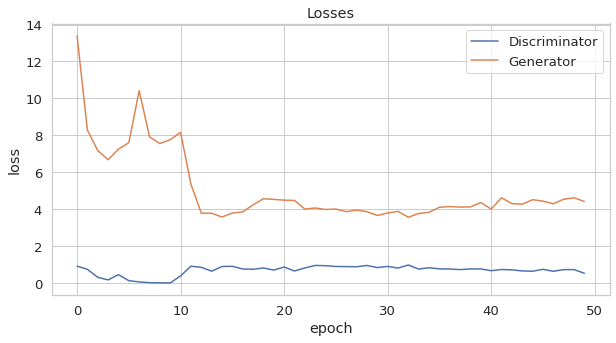

In [ ]:
sns.set_style("whitegrid", {'axes.grid' : True})
plt.figure(figsize=(10, 5))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

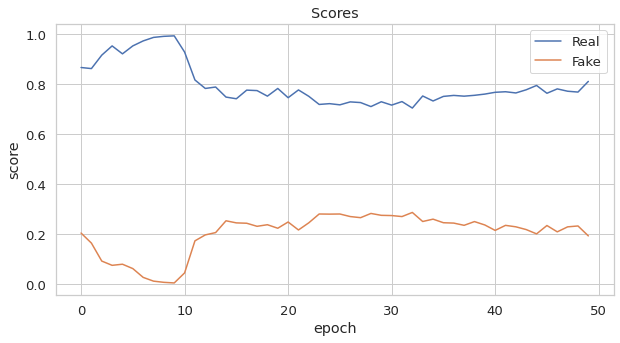

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

## Часть 3. Генерация изображений

Оценим качество получившихся изображений

In [ ]:
n_images = 9

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = denorm(generator(fixed_latent))

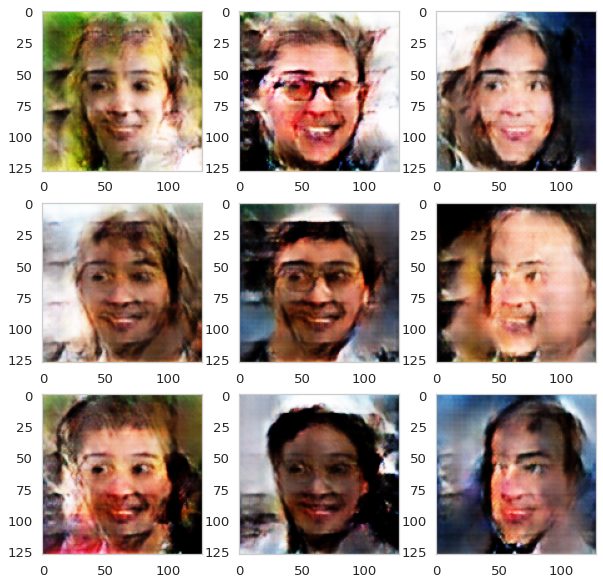

In [ ]:
sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=(10, 10))

for i in range(n_images):
  plt.subplot(3, 3, i+1)
  plt.imshow(fake_images[i].transpose(0,1).transpose(1,2).cpu().detach().numpy())

Качество оставляет желать лучшего, но явно имеем место недообучение. Думаю, что еще порядка 30 эпох существенно изменили бы результат.

## Часть 4. Leave-one-out-1-NN classifier accuracy 

### 4.1. Подсчет accuracy

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы посчитаем Leave-one-out-1-NN classifier accuracy:
  * Сгенерировать N фейковых изображений и взять N настоящих из обучающей выборки. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте при помощи  `sklearn.model_selection.LeaveOneOut`

In [ ]:
# Предобученный классификатор
model_ResNet = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
model_ResNet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Убрать классификатор 
model_ResNet.fc = nn.Sequential() #512

In [ ]:
# Получить представления реальных картинок (5 батчей = 320 картинок)
i = 0
real_result = torch.Tensor()
for batch, _ in train_dl:
  real_result = torch.cat([real_result, model_ResNet(batch.cpu())])
  i += 1
  if (i==5):
    break

In [ ]:
# Получить картинки генератора
latent = torch.randn(len(real_result), latent_size, 1, 1, device=device)
fake_img = model['generator'](latent)

In [ ]:
# Получить представления картинок генератора
fake_result = model_ResNet(fake_img.cpu())

In [ ]:
# Метки
real_labels = torch.ones(len(real_result))
fake_labels = torch.zeros(len(fake_result)) 

labels = torch.cat([real_labels, fake_labels]).cpu().detach().numpy()

In [ ]:
# Картинки
result = torch.cat([real_result, fake_result]).cpu().detach().numpy()

In [ ]:
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [ ]:
# Leave-one-out-1-NN classifier accuracy
y_true, y_pred = list(), list()
loo = LeaveOneOut()

for train_ix, test_ix in loo.split(result):
	# split data
	X_train, X_test = result[train_ix, :], result[test_ix, :]
	y_train, y_test = labels[train_ix], labels[test_ix]

	# fit model
	oneNN = KNeighborsClassifier(n_neighbors=1)
	oneNN.fit(X_train, y_train)

  # evaluate model
	yhat = oneNN.predict(X_test)
 
	# store
	y_true.append(y_test[0])
	y_pred.append(yhat[0])
 
# calculate accuracy
acc = accuracy_score(y_true, y_pred)
print('Accuracy: %.3f' % acc)

Accuracy: 0.666


Accuracy довольно низкий, это ожидаемо как минимум из-за недообучения модели.

### 4.2. Визуализация распределений

Посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого понизим размерность (при помощи TSNE) и изобразим на графике разным цветом точки, соответствующие реальным и сгенерированным изображениям

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
# С помощтю TSNE сжать представления до размерности 2
result_embedded = TSNE(n_components=2, learning_rate='auto').fit_transform(result)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


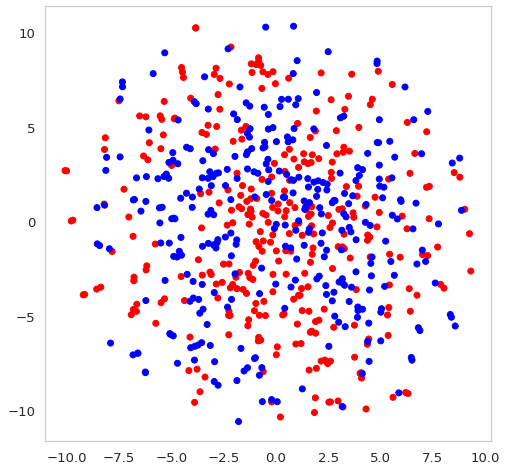

In [ ]:
# Визуализировать полученные двумерные представления с помощью matplotlib.scatter
plt.figure(figsize=(8, 8))
plt.scatter(result_embedded[:, 0], result_embedded[:, 1], c= labels, cmap='bwr')

Видно, что представления картинок не разделимы. Это говорит о том, что генератор хорошо научился создавать изображения, которые нравились бы дискриминатору. Другой вопрос, стали ли они от этого похожи на реальные лица?...